# qPCA clean
Add notebook description here.

To Do:
- include Milas unitary creation
- Data Loading: include test measurement of input state if desired
- notebook descriptions

Library imports:

In [2]:
import numpy as np
from scipy.signal import find_peaks
from scipy.linalg import expm
from collections import defaultdict
from IPython.display import display

from qiskit_aer import *
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import UnitaryGate, PhaseEstimation
from qiskit.circuit.library.data_preparation import StatePreparation

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate, StatePreparation, UnitaryGate
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix, Operator
import matplotlib.pyplot as plt

## Functions
The following functions are defined in this notebook:
- `input_state_preparation(matr, verbose)`: Prepares a quantum circuit from given input matrix.
- `build_PE_circuit(qc_init, U, resolution, verbose)`: Constructs the phase estimation circuit.
- `run_PE_circuit(pe_circuit, simulator, n_shots, plot_results)`: Runs the PE circuit and returns measurement counts.
- `complete_counts(counts, n_qubits)`: Adds zero-count states to count results dict.
- `probability_estimation(pe_counts, n_qubits_register, n_shots)`: Estimates probabilities from PE count results.
- `sign_estimation(pe_circuit, init_circuit, probabilities, simulator, n_shots, verbose)`: Creates and runs sign estimation circuit, returns sign dict.
- `eigen_construction(probabilities, sign_dict, resolution, n_qubits, peak_threshold, verbose)`: Constructs eigenvalues and eigenvectors from measurement outcomes.
- `run_qPCA(input_matr, resolution, simulator, n_shots, verbose)`: Run full qPCA for input matrix, return eigenvalues and vectors.

### Data Loading

In [3]:
def input_state_preparation(matr, rho_copies=2, verbose=False):
    """
    Given a matrix, returns a quantum circuit with the first register as σ,
    and the rest as copies of ρ, all initialized with the same quantum state
    derived from the matrix.

    Args:
        matr (np.ndarray): Matrix to encode into quantum amplitudes.
        rho_copies (int): Number of additional copies of the state for density matrix exponentiation.
        verbose (bool): Print details.

    Returns:
        tuple: (QuantumCircuit, norm_factor)
    """
    # Step 1: Prepare amplitudes
    norm_factor = np.trace(matr)
    matr_normalized = matr / norm_factor
    if verbose: 
        print(f"Normalization factor: {norm_factor}")
        print(f"Normalized matrix:\n{matr_normalized}")

    input_ampl = matr.flatten()
    input_ampl /= np.linalg.norm(input_ampl)
    
    # Ensure proper power of 2
    n_qubits = int(np.ceil(np.log2(len(input_ampl))))
    if 2**n_qubits != len(input_ampl):
        padded = np.zeros(2**n_qubits)
        padded[:len(input_ampl)] = input_ampl
        input_ampl = padded

    # Step 2: Create full circuit
    total_qubits = (rho_copies + 1) * n_qubits
    qc = QuantumCircuit(total_qubits)

    # Step 3: Initialize each block with the same amplitudes
    for i in range(rho_copies + 1):
        qubit_block = list(range(i * n_qubits, (i + 1) * n_qubits))
        init = StatePreparation(input_ampl)
        qc.append(init, qubit_block)

    if verbose:
        print(f"Prepared {rho_copies + 1} registers (σ + ρs) with {n_qubits} qubits each")
        display(qc.draw('mpl'))

    return qc, norm_factor

### Phase estimation

In [4]:
def build_PE_circuit(qc_init, U, resolution=4, verbose=False):
    """
    Constructs the phase estimation (PE) circuit with the given initial state and unitary operator.

    Args:
        qc_init (QuantumCircuit): Quantum circuit with the state preparation.
        U (QuantumCircuit or Gate): Unitary operator to be estimated.
        resolution (int, optional): Number of evaluation qubits. Default: 4.
        verbose (bool, optional): Whether to print debug information and circuit diagram. Default: False.

    Returns:
        QuantumCircuit: Phase estimation circuit (with measurements).
    """
    
    # prepare qiskit phase estimation
    pe = PhaseEstimation(num_evaluation_qubits=resolution, unitary=U, name="PE")
    # prepare counting register
    n_qubits_register = resolution + qc_init.num_qubits
    pe_register = QuantumRegister(n_qubits_register, "register")
    # initialize circuit
    pe_circuit = QuantumCircuit(pe_register)
    pe_circuit.append(qc_init, pe_register[resolution:]) # why? don't fully understand that bit
    pe_circuit.append(pe.to_gate(), pe_register[:pe.num_qubits])
    pe_circuit.measure_all()

    if verbose:
        print(f'Resolution: {resolution}')
        print(f'# qubits for PE: {n_qubits_register}')

        # draw to check
        print("Phase Estimation circuit:")
        display(pe_circuit.decompose(reps=1).draw('mpl'))

    return pe_circuit    

def run_PE_circuit(pe_circuit, simulator=AerSimulator(), n_shots=50000, plot_results=False):
    """
    Execute the (PE) QuantumCircuit with the given simulator and return measurement counts.

    Args:
        pe_circuit (QuantumCircuit): (PE) circuit to execute.
        simulator (Backend): Simulator backend to use.
        n_shots (int, optional): Number of measurement shots. Default: 50000.
        plot_results (bool, optional): Whether to plot a measurement histogram. Default: False.

    Returns:
        dict: Count dictionary with the measurement results.
    """
    
    # transpile the circuit
    pe_transpiled = transpile(pe_circuit, simulator)
    # run circuit
    pe_result = simulator.run(pe_transpiled, shots=n_shots).result()
    # get counts
    pe_counts = pe_result.get_counts()

    # plotting the counts if desired
    if plot_results:
        print("PE result counts:")
        plot = plot_histogram(pe_counts, figsize=(25, 5))
        display(plot)
        
    return pe_counts

### Quantum Tomography

In [5]:
# counts dict by default only contains states that were measured at least once
# so here's quick helper function to get zero count states as well
def complete_counts(counts, n_qubits):
    """
    Add the zero-count states to a qiskit count results dict.

    Args:
        counts (dict): Dictionary of states and measured counts.
        n_qubits (int): Number of measured qubits.

    Returns:
        dict: Dict containing all possible states and counts, incl. zeros.
    """
    keys = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]
    return {k: counts.get(k, 0) for k in keys}

# TODO: possibly inclcude this in the run_PE_circuit() function instead
def probability_estimation(pe_counts, n_qubits_register, n_shots):
    """
    Compute probability estimates from phase estimation measurement counts.

    Args:
        pe_counts (dict): Measurement counts  from the PE circuit.
        n_qubits_register (int): Number of qubits in the PE cicruit.
        n_shots (int): Number of measurement shots used.

    Returns:
        dict: Dictionary of estimated probabilities for each state.
    """
    # get dictionary with added zero count states 
    pe_counts_tot = complete_counts(pe_counts, n_qubits_register)
    # estimate probs from counts
    probabilities = {state: count / n_shots for state, count in pe_counts_tot.items()}
    return probabilities

def sign_estimation(pe_circuit, init_circuit, probabilities, simulator=AerSimulator(), n_shots=50000, verbose=False):
    """
    Estimates the signs (+1 or -1) of the amplitude coefficients. Constructs and runs a sign estimation circuit from the PE
    and state preparation circuits.

    Parameters:
        pe_circuit (QuantumCircuit): Phase estimation circuit.
        init_circuit (QuantumCircuit): Input state preparation circuit.
        probabilities (dict): Dict of estimated probabilities for each state.
        simulator (Backend, optional): Simulator backend to use for running the circuit. Default: `AerSimulator()`.
        n_shots (int, optional): Number of measurement shots. Default: 50000.
        verbose (bool, optional): Whether to print debug information, plot circuit diagram and measurement histogram. Default: False.

    Returns:
        dict: Dictionary mapping states to signs (+1 or -1).
    """
    # adjust PE circuit for sign estimation
    pe_circuit.remove_final_measurements() # remove measurements
    
    # prepare unitaries
    U_p = StatePreparation(np.sqrt(list(probabilities.values())),label='U_p').control()
    # for U_x, we can't use to_gate bc of StatePreparation
    # so we seperate these parts
    # let's hope this works
    del pe_circuit.data[0] # this is wonky but ok
    # to check:
    if verbose:
        print("PE circuit data :")
        print(pe_circuit.data)
        
    # TODO: give the init to the funciton or figure out how to extract!!!!!!   
    U_x_init = init_circuit.control()
    U_x = pe_circuit.to_gate(label='U_x').control()

    n_qubits_pe = pe_circuit.num_qubits
    resolution = n_qubits_pe-init_circuit.num_qubits

    # prepare the sign estimation circuit
    target_register = QuantumRegister(n_qubits_pe, name='Target')
    control_register = QuantumRegister(1, name='Control')
    se_circuit = QuantumCircuit(target_register, control_register, name='SE')
    # add gates
    se_circuit.h(control_register)
    se_circuit.x(control_register)
    se_circuit.append(U_x_init, control_register[:]+target_register[resolution:n_qubits_pe])
    se_circuit.append(U_x, control_register[:]+target_register[:])
    se_circuit.x(control_register)
    se_circuit.append(U_p, control_register[:]+target_register[:])
    se_circuit.h(control_register)
    se_circuit.measure_all()

    if verbose:
        print("Sign estimation circuit:")
        # draw se circuit
        display(se_circuit.draw('mpl'))

    # Run the circuit using Aer simulator
    se_transpiled = transpile(se_circuit, simulator)
    
    # run with N shots
    se_result = simulator.run(se_transpiled, shots=n_shots).result()
    se_counts = se_result.get_counts()

    if verbose: #TODO: or seperate flag for plotting??
        print("SE result counts:")
        plot = plot_histogram(se_counts, figsize=(25, 5))
        display(plot)

    # filter for counts with Control qubit equal 0
    se_counts_filtered = {state[1:]: counts for state, counts in se_counts.items() if state[0]=='0'}
    # pad with zeros?
    # not sure if necessary or correct
    se_counts_filtered = complete_counts(se_counts_filtered, se_circuit.num_qubits-1)
    # compare to find signs:
    sign_dict = {}
    for state, counts in se_counts_filtered.items():
        if counts > 0.4*n_shots*probabilities[state]:
            sign_dict[state] = 1
        else:
            sign_dict[state] = -1
            
    return sign_dict    

### Eigenvalue and -vector reconstruction:

In [6]:
def eigen_construction(probabilities, sign_dict, resolution, n_qubits, peak_threshold=0.001, verbose=False):
    """
    Reconstructs eigenvalue-eigenvector pairs from the phase estimation results.

    Args:
        probabilities (dict): Dict of estimated probabilities for each state.
        sign_dict (dict): Dict mapping states to their estimated signs (+1 or -1).
        resolution (int): Number of evaluation qubits used in the PE circuit.
        n_qubits (int): Number of qubits used to encode the input matrix.
        peak_threshold (float, optional): Minimum prominence of a peak in the eigenvalue 
                                          histogram to consider it a valid eigenvalue.
                                          Default: 0.001.
        verbose (bool, optional): Whether to print debug information. Default: False.

    Returns:
        list of tuples: List of (eigenvalue, eigenvector) tuples.
    """
    # initialise lambdas dict
    lambdas_dict = defaultdict(float) # to avoid missing key checks and init with 0.0
    for state, prob in probabilities.items():
        lam = state[-resolution:]
        lambdas_dict[lam] += prob
    
    # Convert to sorted list
    lambda_keys = sorted(lambdas_dict, key=lambda x: int(x[::-1], 2))
    lambda_probs = np.array([lambdas_dict[k] for k in lambda_keys])
    
    # Find peaks
    peaks_idx, _ = find_peaks(lambda_probs, threshold=peak_threshold) # TODO: investigate threshold more?
    peak_lambda_keys = [lambda_keys[i] for i in peaks_idx]

    if verbose: 
        print("found Peaks: ", peaks_idx, peak_lambda_keys) 
    
    eigvals = []
    eigvecs = []
    for lam in peak_lambda_keys:
        # compute and save eigenvalue
        eigval = int(lam[::-1], 2) / 2**resolution
        eigvals.append(eigval)

        if verbose: 
            print(f"\nEigenvalue: {eigval}")
            
        # collect amplitudes from all relevant states
        amps = [
            (state[:-resolution], sign_dict[state] * np.sqrt(probabilities[state]))
            for state in probabilities if state.endswith(lam)
        ]
        # construct amplitude vector sorted by basis state
        vec = np.array([amp for _, amp in sorted(amps, key=lambda x: x[0])])

        vec /= np.linalg.norm(vec)
    
        # find dominant eigvec
        chunks = vec.reshape(-1, n_qubits) # reshape into eigvec-sized chunks
        max_chunk = np.max(np.abs(chunks), axis=1) # get each chunk's max value
        idx_max = np.argmax(max_chunk) # get index of chunk with max value
        best_chunk = chunks[idx_max] # select chunk with largest value
    
        # this is how they normalize
        eigvec = best_chunk / np.sqrt(np.max(np.abs(best_chunk)))
            
        # they normalized in a slightly different way that confused me greatly
        # I hope this works too?
        #eigvec = best_chunk / np.linalg.norm(best_chunk) # normalize 

        if verbose:
            print("Eigenvector chunks:", chunks)
            print("Max amplitudes: ", max_chunk)
            print("Dominant chunk: ", best_chunk)
        
        eigvecs.append((eigval, eigvec))

    return eigvecs

### Full qPCA

In [ ]:
def swap_exp(delta_t):
    # a tiny circuit that applies the eponential of the SWAP gate
    # since SWAP can be decomposed as S = deltat(II+XX+YY+ZZ)/2 (tensor products between each II XX YY ZZ ofc)

    qc = QuantumCircuit(2) #two bit circuit

    # Apply RXX, RYY, and RZZ with delta_t (note: factor 0.5 absorbed in angle)
    qc.append(RXXGate(2 * delta_t), [0, 1])
    qc.append(RYYGate(2 * delta_t), [0, 1])
    qc.append(RZZGate(2 * delta_t), [0, 1])

    return qc

def densitymatrixexp_unitary(t=1.0, steps=10, rho_copies=3, sigma_qubits=2, rho_qubits=2):
    """
    Returns a UnitaryGate representing the evolution e^{-iρt}
    using SWAP-based density matrix exponentiation. Does NOT
    initialize any states (σ, ρ) — just returns the unitary.

    Args:
        t (float): Total evolution time.
        steps (int): Number of Trotter steps.
        rho_copies (int): Number of copies of ρ.
        sigma_qubits (int): Number of qubits for σ system.
        rho_qubits (int): Number of qubits per ρ copy.

    Returns:
        UnitaryGate: The unitary gate representing e^{-iρt}.
    """
    delta_t = t / steps
    total_qubits = sigma_qubits + rho_copies * rho_qubits

    qr = QuantumRegister(total_qubits)
    qc = QuantumCircuit(qr)

    for _ in range(steps):
        for i in range(rho_copies):
            sigma_idx = list(range(0, sigma_qubits))
            rho_idx = list(range(sigma_qubits + i * rho_qubits,
                                 sigma_qubits + (i + 1) * rho_qubits))
            for s, r in zip(sigma_idx, rho_idx):
                block = swap_exp(delta_t)
                block.qregs = []
                qc.append(block.to_instruction(), [s, r])

    # Now this circuit is unitary
    return UnitaryGate(Operator(qc).data, label="e^{-iρt}")



def run_qPCA(input_matr, resolution: int = 5, simulator=AerSimulator(), n_shots=50000, verbose: bool = False):
    """
    Performs full Quantum Principal Component Analysis (qPCA) on a Hermitian input matrix, returns eigenvalues
    and eigenvectors.

    Parameters:
        input_matr (np.ndarray): Input matrix to perform qPCA on.
        resolution (int, optional): Number of evaluation qubits to use in phase estimation. Default: 5.
        simulator (Backend, optional): Qiskit simulator backend to use. Defaults: `AerSimulator()`.
        n_shots (int, optional): Number of measurement shots for circuit execution. Default: 50000.
        verbose (bool, optional): If True, prints steps, debug info, and intermediate results (such as circuit 
                                diagrams and plots). Default: False.

    Returns:
        list of tuples: List of (eigenvalue, eigenvector) tuples.
    """
    
    # prepare circuit with state preparation according to input matrix
    if verbose: print("\nInput State preparation...")
    qc_init, norm_factor = input_state_preparation(input_matr, verbose=verbose)
    
    # define unitary for phase estimation
    # placeholder until I include the proper unitary creation function
    if verbose: print("\nUnitary gate construction...")
    U = densitymatrixexp_unitary(t=1.0, steps=5, rho_copies=2)
    
    # build phase estimation circuit
    if verbose: print("\nBuilding Phase Estimation circuit...")
    pe_circuit = build_PE_circuit(qc_init, U, resolution=resolution, verbose=verbose)
    
    # run the circuit and get the counts
    if verbose: print("\nRunning Phase Estimation...")
    pe_counts = run_PE_circuit(pe_circuit, simulator=simulator, n_shots=n_shots, plot_results=verbose)
    
    # compute probailities from counts
    if verbose: print("\nProbability estimation...")
    probabilities = probability_estimation(pe_counts, pe_circuit.num_qubits, n_shots)
    
    # estimate the signs 
    if verbose: print("\nSign estimation...")
    sign_dict = sign_estimation(pe_circuit, qc_init, probabilities, simulator=simulator, n_shots=n_shots, verbose=verbose)
    
    # construct eigenvectors and eigenvalues from results
    if verbose: print("\nEigenvalue and -vector construction...")
    eigvecs = eigen_construction(probabilities, sign_dict, resolution, 3 * qc_init.num_qubits, peak_threshold=0.001, verbose=verbose)
    
    # rescale with norm_factor
    eigvecs = [(val * norm_factor, vec) for val, vec in eigvecs]

    # print to check
    if verbose:
        for val, vec in eigvecs:
            print(f'Eigenvalue: {val.round(3)}, eigenvector: {vec.round(3)}')
        print("Done!")
        
    return eigvecs

## Main


Input State preparation...
Normalization factor: 3.0
Normalized matrix:
[[0.5        0.16666667]
 [0.16666667 0.5       ]]
Prepared 3 registers (σ + ρs) with 2 qubits each


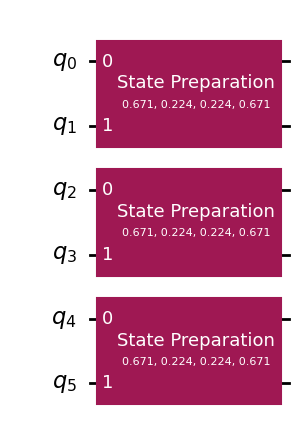


Unitary gate construction...

Building Phase Estimation circuit...
Resolution: 3
# qubits for PE: 9
Phase Estimation circuit:


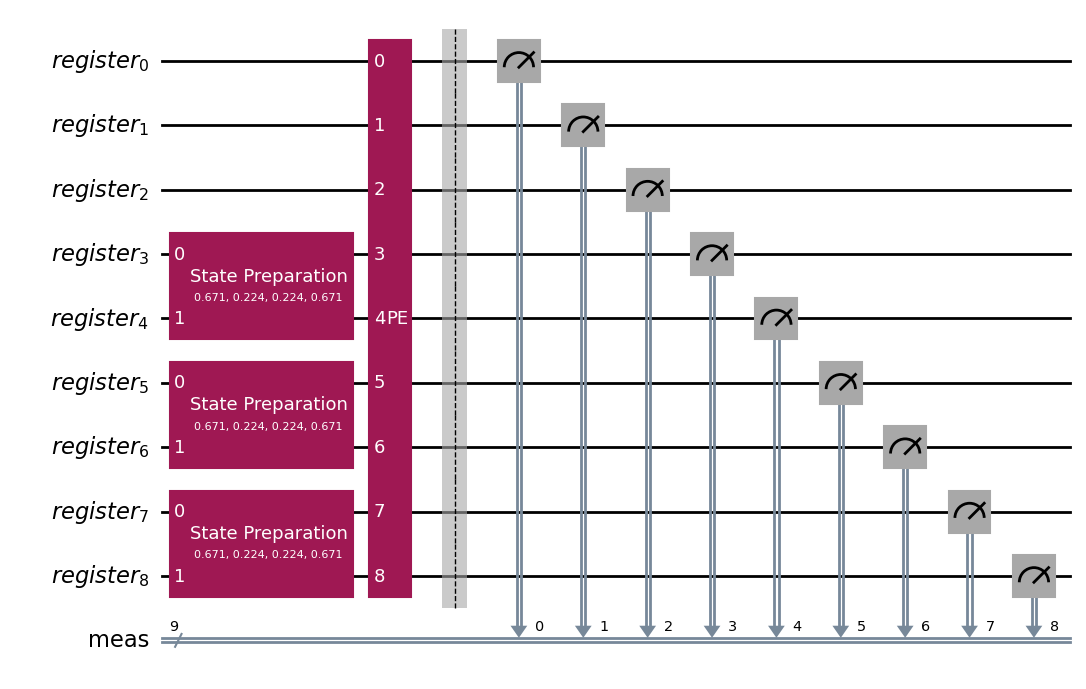


Running Phase Estimation...
PE result counts:


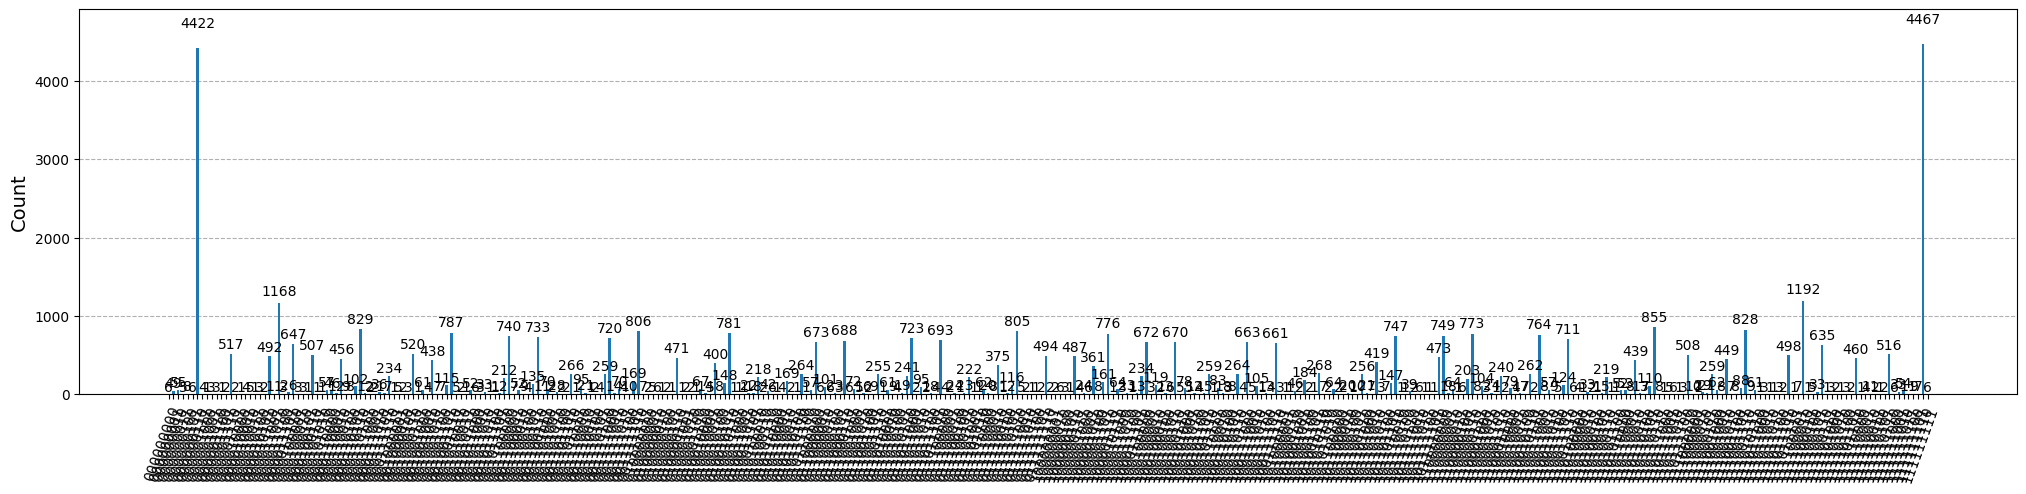


Probability estimation...

Sign estimation...
PE circuit data :
[CircuitInstruction(operation=Instruction(name='PE', num_qubits=9, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(9, 'register'), 0), Qubit(QuantumRegister(9, 'register'), 1), Qubit(QuantumRegister(9, 'register'), 2), Qubit(QuantumRegister(9, 'register'), 3), Qubit(QuantumRegister(9, 'register'), 4), Qubit(QuantumRegister(9, 'register'), 5), Qubit(QuantumRegister(9, 'register'), 6), Qubit(QuantumRegister(9, 'register'), 7), Qubit(QuantumRegister(9, 'register'), 8)), clbits=())]
Sign estimation circuit:


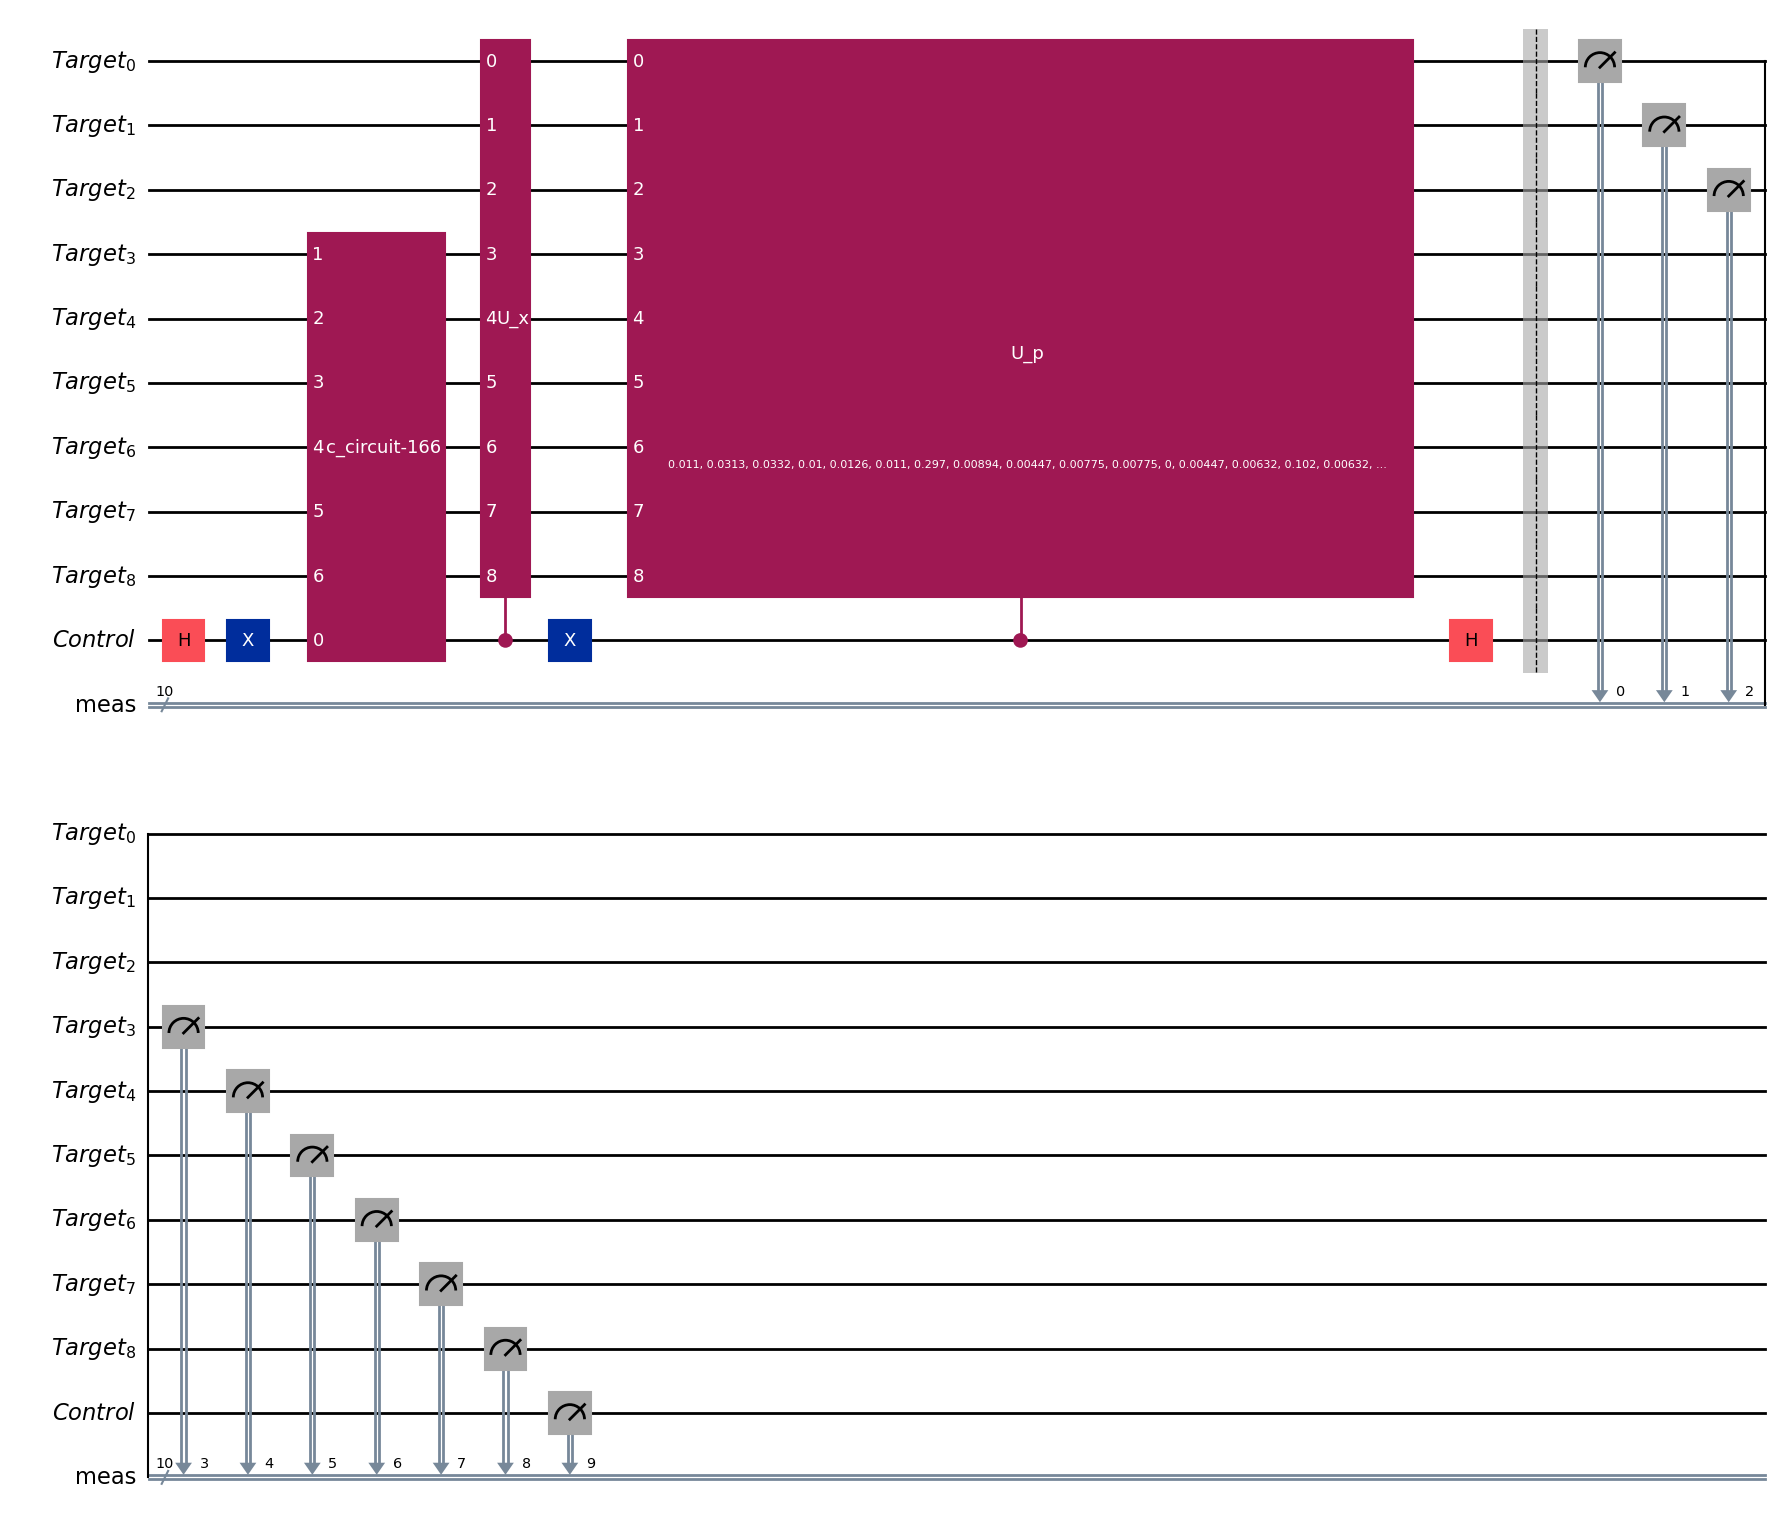

SE result counts:


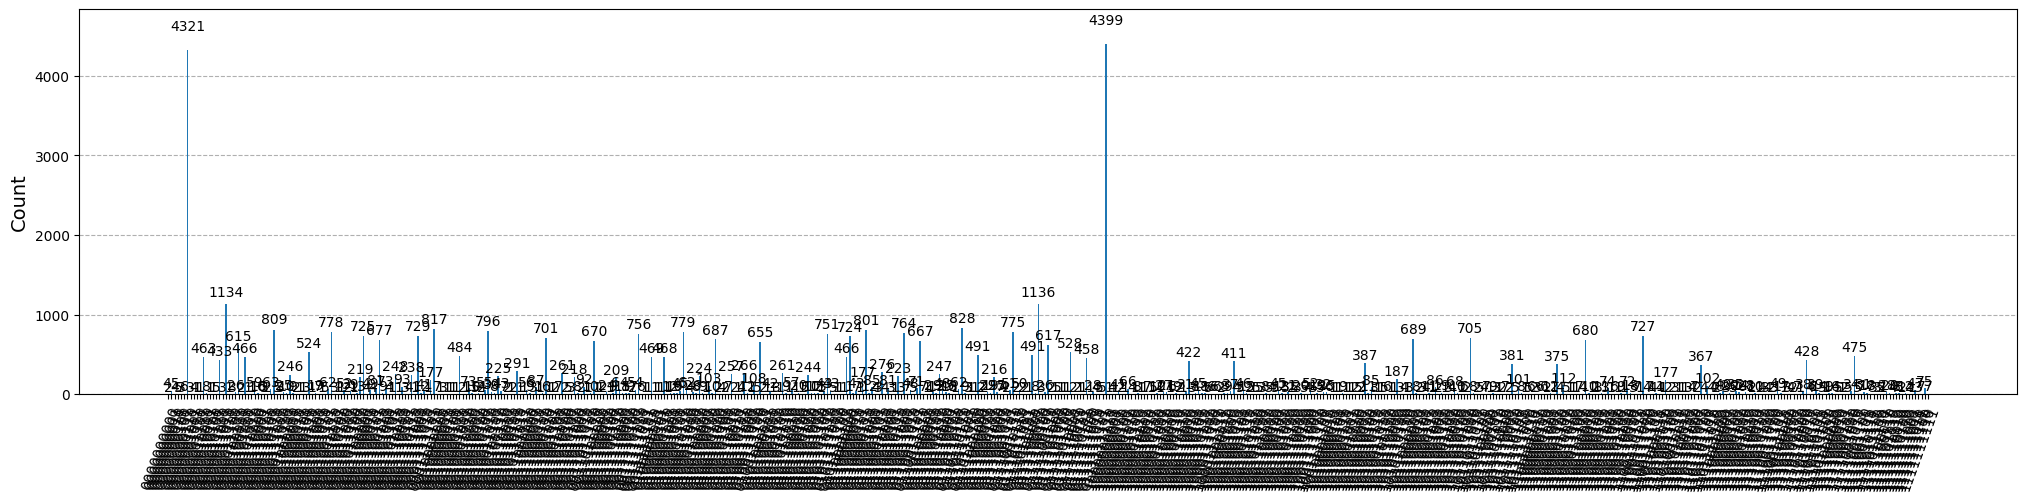


Eigenvalue and -vector construction...
found Peaks:  [3 5] ['110', '101']

Eigenvalue: 0.375


ValueError: cannot reshape array of size 64 into shape (6)

In [8]:
# input matrix for testing
matr = np.array([[1.5, 0.5],[0.5, 1.5]])
eigvecs = run_qPCA(matr, resolution=3, verbose=True)

In [ ]:
for res in range(3, 15):
    print(f'\nUsing {res} resolution qubits')
    eigvecs = run_qPCA(matr, resolution=res)
    for val, vec in eigvecs:
        #print(f'Eigenvalue: {val.round(3)}, eigenvector: {vec.round(3)}')  
        print(f'eigenvalue: {val}')
        print(f'eigenvector: {vec.round(3)}')


Using 3 resolution qubits
eigenvalue: 1.125
eigenvector: [ 0.755 -0.559]
eigenvalue: 1.875
eigenvector: [0.72  0.668]

Using 4 resolution qubits
eigenvalue: 0.9375
eigenvector: [-0.563  0.754]
eigenvalue: 2.0625
eigenvector: [0.721 0.663]

Using 5 resolution qubits
eigenvalue: 1.03125
eigenvector: [ 0.723 -0.674]
eigenvalue: 1.96875
eigenvector: [0.71  0.699]

Using 6 resolution qubits
eigenvalue: 0.984375
eigenvector: [ 0.723 -0.66 ]
eigenvalue: 2.015625
eigenvector: [0.697 0.711]

Using 7 resolution qubits
eigenvalue: 1.0078125
eigenvector: [-0.706  0.71 ]
eigenvalue: 1.9921875
eigenvector: [0.709 0.703]

Using 8 resolution qubits
eigenvalue: 0.99609375
eigenvector: [ 0.717 -0.683]
eigenvalue: 2.00390625
eigenvector: [0.71  0.703]

Using 9 resolution qubits
eigenvalue: 1.001953125
eigenvector: [ 0.712 -0.696]
eigenvalue: 1.998046875
eigenvector: [0.709 0.706]

Using 10 resolution qubits
eigenvalue: 0.9990234375
eigenvector: [ 0.699 -0.71 ]
eigenvalue: 2.0009765625
eigenvector: [0.71